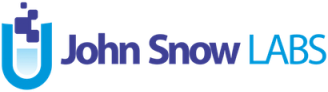

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/blogposts/Healthcare_NER_Model_Evaluation_with_LangTest.ipynb)

# Evaluating Robustness, Bias, and Accuracy in Healthcare NER Models

In this blog post, we will compare the performance of two named entity recognition (NER) healthcare models: **med7** and **ner_posology_langtest**. NER models are crucial for extracting relevant information from clinical text, enabling tasks like medication extraction, dosage identification, and more.

## Model Overview

1. **med7** - [GitHub Repository](https://github.com/kormilitzin/med7)

   Med7 is a transferable clinical natural language processing model compatible with spaCy v3+. It is trained on the free-text electronic health records dataset called `MIMIC-III`. The model recognizes seven categories, including Drug, Duration, Strength, Form, Frequency, Dosage, and Route. Med7 offers a powerful solution for clinical NER tasks.

2. **ner_posology_langtest** - John Snow Labs Model

   The ner_posology_langtest model is a pretrained deep learning model for posology NER by John Snow Labs. It leverages the `embeddings_clinical` word embeddings model and predicts similar entities as med7. This model is also designed specifically for healthcare-related tasks.


- To evaluate the performance and compare the robustness, bias, and accuracy of both models, we will be using **langtest**.


### LangTest

**LangTest** is an open-source Python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using models from **John Snow Labs**, **Hugging Face**, **spaCy**, or LLMs from **OpenAI**, **Cohere**, **AI21**, **Hugging Face Inference API**, or **Azure-OpenAI**, LangTest has got you covered. It provides a comprehensive set of tests for evaluating Named Entity Recognition (NER), Text Classification, Question-Answering, and Summarization models. The library supports over 50 out-of-the-box tests, categorized into robustness, accuracy, bias, representation, and fairness.



### Robustness Testing

Model robustness can be described as the ability of a model to keep similar levels of accuracy, precision and recall when perturbations are made to the data it is predicting on. For example, in the case of NER, the goal is to understand how documents with typos or fully uppercased sentences affect the model's prediction performance compared to documents similar to those in the original training set.


**`Supported Robustness tests :`**<br>


- **`uppercase`**: capitalization of the test set is turned into uppercase

- **`lowercase`**: capitalization of the test set is turned into lowercase

- **`titlecase`**: capitalization of the test set is turned into title case

- **`add_punctuation`**: special characters at end of each sentence are replaced by other special characters, if no
special character at the end, one is added

- **`strip_punctuation`**: special characters are removed from the sentences (except if found in numbers, such as '2.5')

- **`add_typo`**: typos are introduced in sentences

- **`add_contraction`**: contractions are added where possible (e.g. 'do not' contracted into 'don't')

- **`add_context`**: tokens are added at the beginning and at the end of the sentences

- **`swap_entities`**: named entities replaced with same entity type with same token count from terminology

- **`swap_cohyponyms`**: Named entities replaced with co-hyponym from the WordNet database

- **`american_to_british`**: American English will be changed to British English

- **`british_to_american`**: British English will be changed to American English

- **`number_to_word`**: Converts numeric values in sentences to their equivalent verbal representation.

- **`add_ocr_typo`**: Ocr typos are introduced in sentences

- **`multiple_perturbations`** : Transforms the given sentences by applying multiple perturbations in a specific sequence.

- **`add_speech_to_text_typo`**: Introduce common conversion errors from SSpeech to Text conversion.

- **`add_abbreviation`**:Replaces words or expressions in texts with their abbreviations

- **`adjective_synonym_swap`** : Transforms the adjectives in the given sentences to their synonyms.

- **`adjective_antonym_swap`** : Transforms the adjectives in the given sentences to their antonyms.

<br/>

<br/>

### Bias Testing

Model bias refers to the phenomenon where the model produces results that are systematically skewed in a particular direction. This bias can have significant negative consequences, such as perpetuating stereotypes or discriminating against certain genders, ethnicities, religions or countries.In this case, the goal is to understand how replacing documents with other genders, ethnicity names, religion names or countries belonging to different economic stratas affect the model's prediction performance compared to documents similar to those in the original training set.



**`Supported Bias tests :`**<br>


- **`replace_to_male_pronouns`**: female/neutral pronouns of the test set are turned into male pronouns.

- **`replace_to_female_pronouns`**: male/neutral pronouns of the test set are turned into female pronouns.

- **`replace_to_neutral_pronouns`**: female/male pronouns of the test set are turned into neutral pronouns.

- **`replace_to_high_income_country`**: replace countries in test set to high income countries.

- **`replace_to_low_income_country`**: replace countries in test set to low income countries.
- **`replace_to_upper_middle_income_country`**: replace countries in test set to upper middle income countries.

- **`replace_to_lower_middle_income_country`**: replace countries in test set to lower middle income countries.

- **`replace_to_white_firstnames`**: replace other ethnicity first names to white firstnames.

- **`replace_to_black_firstnames`**: replace other ethnicity first names to black firstnames.

- **`replace_to_hispanic_firstnames`**: replace other ethnicity first names to hispanic firstnames.

- **`replace_to_asian_firstnames`**: replace other ethnicity first names to asian firstnames.

- **`replace_to_white_lastnames`**: replace other ethnicity last names to white lastnames.

- **`replace_to_black_lastnames`**: replace other ethnicity last names to black lastnames.

- **`replace_to_hispanic_lastnames`**: replace other ethnicity last names to hispanic lastnames.

- **`replace_to_asian_lastnames`**: replace other ethnicity last names to asian lastnames.

- **`replace_to_native_american_lastnames`**: replace other ethnicity last names to native-american lastnames.

- **`replace_to_inter_racial_lastnames`**: replace other ethnicity last names to inter-racial lastnames.

- **`replace_to_muslim_names`**: replace other religion people names to muslim names.

- **`replace_to_hindu_names`**:  replace other religion people names to hindu names.

- **`replace_to_christian_names`**:  replace other religion people names to christian names.

- **`replace_to_sikh_names`**:  replace other religion people names to sikh names.

- **`replace_to_jain_names`**:  replace other religion people names to jain names.

- **`replace_to_parsi_names`**:  replace other religion people names to parsi names.

- **`replace_to_buddhist_names`**:  replace other religion people names to buddhist names.


<br/>
<br/>

### Fairness Testing

Fairness testing is a critical aspect of evaluating the performance of a machine learning model, especially when the model has potential implications for specific groups of people. Fairness testing aims to ensure that the model is not biased towards or against any particular group and that it produces unbiased results for all groups.
To support fairness testing, several fairness tests are available, which evaluate the model's performance on various attributes such as gender.

**`Supported Fairness tests :`**<br>

- **`min_gender_f1_score`**: Determine if any gender(male, female or unknown) has less than the desired f1 score.

- **`max_gender_f1_score`**:  Determine if any gender(male, female or unknown) has more than the desired f1 score.


<br/>
<br/>

### Representation Testing

The goal of representation testing is to determine if a given dataset represents a specific population accurately or if it contains biases that could negatively impact the results of any analysis conducted on it.




**`Supported Representation tests :`**<br>

- **`min_gender_representation_count`**: Determine if any gender(male, female or unknown) has less than the desired minimum representation count.

- **`min_gender_representation_proportion`**:  Determine if any gender(male, female or unknown) has less than the desired minimum representation proportion.

- **`min_ethnicity_name_representation_count`**: Determine if any ethnicity(black, asian, white, native_american, hispanic or inter_racial) has less than the desired minimum representation count.

- **`min_ethnicity_name_representation_proportion`**: Determine if any ethnicity(black, asian, white, native_american, hispanic or inter_racial) has less than the desired minimum representation proportion.

- **`min_label_representation_count`**: Determine if any label(O, LOC, PER, MISC or ORG) has less than the desired minimum representation count.

- **`min_label_representation_proportion`**: Determine if any label(O, LOC, PER, MISC or ORG) has less than the desired minimum representation proportion.

- **`min_religion_name_representation_count`**: Determine if any religion(muslim, hindu, sikh, christian, jain, buddhist or parsi) has less than the desired minimum representation count.

- **`min_religion_name_representation_proportion`**: Determine if any religion(muslim, hindu, sikh, christian, jain, buddhist or parsi) has less than the desired minimum representation proportion.

- **`min_country_economic_representation_count`**: Determine if any country(high_income, low_income, lower_middle_income or upper_middle_income) has less than the desired minimum representation count.

- **`min_country_economic_representation_proportion`**:Determine if any country(high_income, low_income, lower_middle_income or upper_middle_income) has less than the desired minimum representation proportion.

<br/>
<br/>

### Accuracy Testing

Accuracy testing is a crucial step in evaluating the performance of a machine learning model. It involves measuring how well the model can correctly predict outcomes on a test dataset, which it has not seen before. The accuracy of a model is determined by comparing its predicted output with the actual output. To support the accuracy testing process, several accuracy tests are available. These tests aim to evaluate various aspects of a model's performance both labelwise such as its precision, recall, F1 score and overall like micro F1 score, macro F1 score, and weighted F1 score.


**`Supported Accuracy tests :`**

- **`min_precision_score`**: Determine if the actual precision score is less than the desired precision score.

- **`min_recall_score`**:  Determine if the actual recall score is less than the desired recall score.

- **`min_f1_score`**: Determine if the actual f1 score is less than the desired f1 score.

- **`min_micro_f1_score`**:  Determine if the actual micro-f1 score is less than the desired micro-f1 score.

- **`min_macro_f1_score`**:  Determine if the actual macro-f1 score is less than the desired macro-f1 score.

- **`min_weighted_f1_score`**:  Determine if the actual min-weighted-f1 score is less than the desired min-weighted-f1 score.


## Med7 model

####  Install the model:

In [ ]:
# Vectors model
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl

### To utilize the `med7` model, you can follow these steps:

In [ ]:
import spacy

# Load the med7 model
med7 = spacy.load("en_core_med7_lg")

# create distinct colours for labels
col_dict = {}
seven_colours = ['#e6194B', '#3cb44b', '#ffe119', '#ffd8b1', '#f58231', '#f032e6', '#42d4f4']
for label, colour in zip(med7.pipe_labels['ner'], seven_colours):
    col_dict[label] = colour

# Specify rendering options for entity visualization
options = {'ents': med7.pipe_labels['ner'], 'colors':col_dict}

# Define the input text to process
text = 'The patient is a 30-year-old female with a long history of insulin dependent diabetes, type 2; coronary artery disease; chronic renal insufficiency; peripheral vascular disease, also secondary to diabetes; who was originally admitted to an outside hospital for what appeared to be acute paraplegia, lower extremities. She did receive a course of Bactrim for 14 days for UTI. Evidently, at some point in time, the patient was noted to develop a pressure-type wound on the sole of her left foot and left great toe. She was also noted to have a large sacral wound; this is in a similar location with her previous laminectomy, and this continues to receive daily care. The patient was transferred secondary to inability to participate in full physical and occupational therapy and continue medical management of her diabetes, the sacral decubitus, left foot pressure wound, and associated complications of diabetes. She is given Fragmin 5000 units subcutaneously daily, Xenaderm to wounds topically b.i.d., Lantus 40 units subcutaneously at bedtime, OxyContin 30 mg p.o. q.12 h., folic acid 1 mg daily, levothyroxine 0.1 mg p.o. daily, Prevacid 30 mg daily, Avandia 4 mg daily, Norvasc 10 mg daily, Lexapro 20 mg daily, aspirin 81 mg daily, Senna 2 tablets p.o. q.a.m., Neurontin 400 mg p.o. t.i.d., Percocet 5/325 mg 2 tablets q.4 h. p.r.n., magnesium citrate 1 bottle p.o. p.r.n., sliding scale coverage insulin, Wellbutrin 100 mg p.o. daily, and Bactrim DS b.i.d.'

# Process the text using the med7 model
doc = med7(text)

# Visualize the entities in the text
spacy.displacy.render(doc, style='ent', jupyter=True, options=options)

[(ent.text, ent.label_) for ent in doc.ents]

[('insulin', 'DRUG'),
 ('Bactrim', 'DRUG'),
 ('for 14 days', 'DURATION'),
 ('daily', 'FREQUENCY'),
 ('Fragmin', 'DRUG'),
 ('5000 units', 'DOSAGE'),
 ('subcutaneously', 'ROUTE'),
 ('daily', 'FREQUENCY'),
 ('Xenaderm', 'DRUG'),
 ('topically', 'ROUTE'),
 ('b.i.d.', 'FREQUENCY'),
 ('Lantus', 'DRUG'),
 ('40 units', 'STRENGTH'),
 ('subcutaneously', 'ROUTE'),
 ('at bedtime', 'FREQUENCY'),
 ('OxyContin', 'DRUG'),
 ('30 mg', 'STRENGTH'),
 ('p.o.', 'ROUTE'),
 ('q.12 h.', 'FREQUENCY'),
 ('folic acid', 'DRUG'),
 ('1 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('levothyroxine', 'DRUG'),
 ('0.1 mg', 'STRENGTH'),
 ('p.o.', 'ROUTE'),
 ('daily', 'FREQUENCY'),
 ('Prevacid', 'DRUG'),
 ('30 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('Avandia', 'DRUG'),
 ('4 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('Norvasc', 'DRUG'),
 ('10 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('Lexapro', 'DRUG'),
 ('20 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('aspirin', 'DRUG'),
 ('81 mg', 'STRENGTH'),
 ('daily', 'FREQUEN

## ner_posology_langtest model

**Setting up License Keys for ner_posology_langtest Model**

In [6]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)


**Installing Required Packages**

In [7]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

**Setting up Spark NLP and Spark Session**

In [8]:
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql.types import StringType, IntegerType

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 4.4.4
Spark NLP_JSL Version : 4.4.4


The code above imports the required libraries, sets up the Spark Session, and initializes Spark NLP. Additionally, it configures parameters for Spark NLP, such as memory allocation and buffer size, to ensure optimal performance.

After running this code, you'll have the Spark Session set up with Spark NLP and be ready to proceed with utilizing the `ner_posology_langtest` model for NLP tasks.

### Define Spark NLP pipeline

To learn about the Spark NLP pipeline, you can refer to the official documentation at [Spark NLP Pipeline Documentation](https://nlp.johnsnowlabs.com/docs/en/jsl/nlp_pipes)

To process the text and extract the desired entities using the `ner_posology_langtest` model, you need to build an NLP pipeline. Run the following code to define the pipeline stages and apply the pipeline to the input text:

In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
	.setInputCols(["sentence", "token"])\
	.setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_posology_langtest","en","clinical/models")\
 .setInputCols(["sentence","token","embeddings"])\
 .setOutputCol("ner")

ner_converter = NerConverter()\
 	.setInputCols(["sentence", "token", "ner"])\
 	.setOutputCol("ner_chunk")

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_detector, tokenizer, word_embeddings, clinical_ner, ner_converter])

model = nlp_pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

result = model.transform(spark.createDataFrame([['The patient is a 30-year-old female with a long history of insulin dependent diabetes, type 2; coronary artery disease; chronic renal insufficiency; peripheral vascular disease, also secondary to diabetes; who was originally admitted to an outside hospital for what appeared to be acute paraplegia, lower extremities. She did receive a course of Bactrim for 14 days for UTI. Evidently, at some point in time, the patient was noted to develop a pressure-type wound on the sole of her left foot and left great toe. She was also noted to have a large sacral wound; this is in a similar location with her previous laminectomy, and this continues to receive daily care. The patient was transferred secondary to inability to participate in full physical and occupational therapy and continue medical management of her diabetes, the sacral decubitus, left foot pressure wound, and associated complications of diabetes. She is given Fragmin 5000 units subcutaneously daily, Xenaderm to wounds topically b.i.d., Lantus 40 units subcutaneously at bedtime, OxyContin 30 mg p.o. q.12 h., folic acid 1 mg daily, levothyroxine 0.1 mg p.o. daily, Prevacid 30 mg daily, Avandia 4 mg daily, Norvasc 10 mg daily, Lexapro 20 mg daily, aspirin 81 mg daily, Senna 2 tablets p.o. q.a.m., Neurontin 400 mg p.o. t.i.d., Percocet 5/325 mg 2 tablets q.4 h. p.r.n., magnesium citrate 1 bottle p.o. p.r.n., sliding scale coverage insulin, Wellbutrin 100 mg p.o. daily, and Bactrim DS b.i.d.']], ["text"]))

To access the extracted entities from the result, you can run the following code:

In [ ]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                     result.ner_chunk.metadata)).alias("cols"))\
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show()

+--------------+---------+
|         chunk|ner_label|
+--------------+---------+
|       insulin|     DRUG|
|       Bactrim|     DRUG|
|   for 14 days| DURATION|
|       Fragmin|     DRUG|
|    5000 units| STRENGTH|
|subcutaneously|    ROUTE|
|         daily|FREQUENCY|
|      Xenaderm|     DRUG|
|     topically|    ROUTE|
|         b.i.d|FREQUENCY|
|        Lantus|     DRUG|
|      40 units|   DOSAGE|
|subcutaneously|    ROUTE|
|    at bedtime|FREQUENCY|
|     OxyContin|     DRUG|
|         30 mg| STRENGTH|
|           p.o|    ROUTE|
|    folic acid|     DRUG|
|          1 mg| STRENGTH|
|         daily|FREQUENCY|
+--------------+---------+
only showing top 20 rows



To visualize the extracted entities, you can use the `NerVisualizer` class from the `sparknlp_display` library. Run the following code:

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(result = result.collect()[0] ,label_col = 'ner_chunk', document_col = 'document')

# Evaluating Model Performance with LangTest

To use LangTest, you can install it using pip

In [ ]:
!pip install langtest

# Harness and its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [11]:
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>


| Parameter  | Description |
| - | - |
|**task**     |Task for which the model is to be evaluated (text-classification or ner)|
|**model**     |PipelineModel or path to a saved model or pretrained pipeline/model from hub.
|**data**       |Path to the data that is to be used for evaluation. Can be .csv or .conll file in the CoNLL format
|**config**     |Configuration for the tests to be performed, specified in form of a YAML file.
|**hub**       |model hub to load from the path. Required if model param is passed as path.|

<br/>
<br/>

### Test Configuration

Test configuration can be passed in the form of a YAML file as shown below or using .configure() method


**Config YAML format** :
```
tests:
  defaults:
    min_pass_rate: 0.65
  bias:
    replace_to_high_income_country:
      min_pass_rate: 0.66
    replace_to_low_income_country:
      min_pass_rate: 0.60

```

If config file is not present, we can also use the **.configure()** method to manually configure the harness to perform the needed tests.

# Testing Med7 model

we have instantiated the Harness class to perform NER testing on the Med7 model. We have specified the test data, set the task to "ner", and provided the model name and hub information.

In [13]:
harness = Harness(
            data="testing/sample-pos.conll",
            task = "ner",
            model="en_core_med7_lg",
            hub = "spacy"
        )

2023-07-28 06:54:11.998228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Test Configuration : 
 {
 "tests": {
  "defaults": {
   "min_pass_rate": 1.0
  },
  "robustness": {
   "add_typo": {
    "min_pass_rate": 0.7
   },
   "american_to_british": {
    "min_pass_rate": 0.7
   }
  },
  "accuracy": {
   "min_micro_f1_score": {
    "min_score": 0.7
   }
  },
  "bias": {
   "replace_to_female_pronouns": {
    "min_pass_rate": 0.7
   },
   "replace_to_low_income_country": {
    "min_pass_rate": 0.7
   }
  },
  "fairness": {
   "min_gender_f1_score": {
    "min_score": 0.6
   }
  },
  "representation": {
   "min_label_representation_count": {
    "min_count": 50
   }
  }
 }
}


### Configure the Tests
We can use the .configure() method to manually configure the tests we want to perform.

In [14]:
harness.configure(
{
 'tests': {'defaults': {'min_pass_rate': 0.65},
           'robustness': {'uppercase': {'min_pass_rate': 0.60},
                          'lowercase': {'min_pass_rate': 0.60},
                          'titlecase':{'min_pass_rate': 0.60},
                          'add_punctuation':{'min_pass_rate': 0.60},
                          'strip_punctuation':{'min_pass_rate': 0.60},
                          'add_slangs':{'min_pass_rate': 0.60},
                          'dyslexia_word_swap':{'min_pass_rate': 0.60},
                          'add_abbreviation':{'min_pass_rate': 0.60},
                          'add_speech_to_text_typo':{'min_pass_rate': 0.60},
                          'number_to_word':{'min_pass_rate': 0.60},
                          'add_ocr_typo':{'min_pass_rate': 0.60},
                          'adjective_synonym_swap':{'min_pass_rate': 0.60}
                        },
                'bias': {'replace_to_male_pronouns': {'min_pass_rate': 0.66},
                          'replace_to_female_pronouns':{'min_pass_rate': 0.60},
                           'replace_to_inter_racial_lastnames':{'min_pass_rate': 0.60},
                           'replace_to_native_american_lastnames':{'min_pass_rate': 0.60},
                           'replace_to_asian_lastnames':{'min_pass_rate': 0.60},
                        },
              'accuracy': {'min_precision_score': {'min_score': 0.66},
                          'min_recall_score':{'min_score': 0.60},
                        'min_f1_score':{'min_score': 0.60},
                        'min_micro_f1_score':{'min_score': 0.60}
                        }

          }
 }
)

{'tests': {'defaults': {'min_pass_rate': 0.65},
  'robustness': {'uppercase': {'min_pass_rate': 0.6},
   'lowercase': {'min_pass_rate': 0.6},
   'titlecase': {'min_pass_rate': 0.6},
   'add_punctuation': {'min_pass_rate': 0.6},
   'strip_punctuation': {'min_pass_rate': 0.6},
   'add_slangs': {'min_pass_rate': 0.6},
   'dyslexia_word_swap': {'min_pass_rate': 0.6},
   'add_abbreviation': {'min_pass_rate': 0.6},
   'add_speech_to_text_typo': {'min_pass_rate': 0.6},
   'number_to_word': {'min_pass_rate': 0.6},
   'add_ocr_typo': {'min_pass_rate': 0.6},
   'adjective_synonym_swap': {'min_pass_rate': 0.6}},
  'bias': {'replace_to_male_pronouns': {'min_pass_rate': 0.66},
   'replace_to_female_pronouns': {'min_pass_rate': 0.6},
   'replace_to_inter_racial_lastnames': {'min_pass_rate': 0.6},
   'replace_to_native_american_lastnames': {'min_pass_rate': 0.6},
   'replace_to_asian_lastnames': {'min_pass_rate': 0.6}},
  'accuracy': {'min_precision_score': {'min_score': 0.66},
   'min_recall_score':

Here we have configured the harness to perform robustness, bias and accuracy tests. For each test category, we have specified the minimum pass rates and additional parameters where applicable.

### Generating the test cases.

In [15]:
harness.generate()

Generating testcases...: 100%|██████████| 3/3 [00:00<00:00, 17747.41it/s]


harness.generate() method automatically generates the test cases (based on the provided configuration)

In [16]:
harness.testcases()

,category,test_type,original,test_case
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA..."
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR..."
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...
...,...,...,...,...
25520,accuracy,min_f1_score,-,DOSAGE
25521,accuracy,min_f1_score,-,FREQUENCY
25522,accuracy,min_f1_score,-,DRUG
25523,accuracy,min_f1_score,-,O


harness.testcases() method gives the produced test cases in form of a pandas data frame.

### Running the tests

In [17]:
harness.run()

Running testcases... : 100%|██████████| 25525/25525 [09:46<00:00, 43.49it/s]


Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

### Generated Results

In [18]:
harness.generated_results()

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA...","amiodarone hydrochloride: DRUG, 800 mg/: STRENGTH, day: FREQUENCY, for one month: DURATION, 400 mg/: STRENGTH, day: FREQUENCY",AMIODARONE HYDROCHLORIDE DOSE: DRUG,False
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .,"One: DOSAGE, VANDAZOLE: DRUG, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, FOR 5 DAYS: DURATION",False
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR...","Potassium Chloride: DRUG, USP: DRUG, 8 mEq: STRENGTH, 10 mEq: STRENGTH","USP: DRUG, 8: DOSAGE, MEQ: DRUG, 10: DOSAGE",False
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...,"hydrochloride: DRUG, capsules: FORM, levodopa: DRUG, carbidopa: DRUG",,False
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...,,,True
...,...,...,...,...,...,...,...
25520,accuracy,min_f1_score,-,DOSAGE,0.6,0.357143,False
25521,accuracy,min_f1_score,-,FREQUENCY,0.6,0.771729,True
25522,accuracy,min_f1_score,-,DRUG,0.6,0.775194,True
25523,accuracy,min_f1_score,-,O,0.6,0.962597,True


This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

In [19]:
df= harness.generated_results()

### Generated Results For robustness

In [20]:
df[df["category"]=="robustness"]

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA...","amiodarone hydrochloride: DRUG, 800 mg/: STRENGTH, day: FREQUENCY, for one month: DURATION, 400 mg/: STRENGTH, day: FREQUENCY",AMIODARONE HYDROCHLORIDE DOSE: DRUG,False
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .,"One: DOSAGE, VANDAZOLE: DRUG, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, FOR 5 DAYS: DURATION",False
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR...","Potassium Chloride: DRUG, USP: DRUG, 8 mEq: STRENGTH, 10 mEq: STRENGTH","USP: DRUG, 8: DOSAGE, MEQ: DRUG, 10: DOSAGE",False
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...,"hydrochloride: DRUG, capsules: FORM, levodopa: DRUG, carbidopa: DRUG",,False
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...,,,True
...,...,...,...,...,...,...,...
17995,robustness,adjective_synonym_swap,"The sooner you take emergency contraception , the better it works .","The sooner you take emergency contraception , the superior it works .",,,True
17996,robustness,adjective_synonym_swap,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,"Omeprazole: DRUG, esomeprazole: DRUG, Clopidogrel: DRUG","Omeprazole: DRUG, esomeprazole: DRUG, Clopidogrel: DRUG",True
17997,robustness,adjective_synonym_swap,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the appropriate diluent ( see COMPATIBILITY AND STABILITY : ).,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the convenient diluent ( see COMPATIBILITY AND STABILITY : ).,"Reconstitute: DRUG, ceftriaxone: DRUG, powder: FORM","Reconstitute: DRUG, ceftriaxone: DRUG, powder: FORM",True
17998,robustness,adjective_synonym_swap,2.4 Dosage Adjustment Patients with Rash Discontinue nevirapine if a patient experiences severe rash or any rash accompanied by constitutional findings [see Warnings and Precautions ( 5.2)] .,2.4 Dosage Adjustment Patients with Rash Discontinue nevirapine if a patient experiences serious audacious or all audacious accompanied by constitutional findings [see Warnings and Precautions ( 5...,nevirapine: DRUG,nevirapine: DRUG,True


### Generated Results For bias

In [21]:
df[df["category"]=="bias"]

,category,test_type,original,test_case,expected_result,actual_result,pass
18000,bias,replace_to_male_pronouns,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","amiodarone hydrochloride: DRUG, 800 mg/: STRENGTH, day: FREQUENCY, for one month: DURATION, 400 mg/: STRENGTH, day: FREQUENCY","amiodarone hydrochloride: DRUG, 800 mg/: STRENGTH, day: FREQUENCY, for one month: DURATION, 400 mg/: STRENGTH, day: FREQUENCY",True
18001,bias,replace_to_male_pronouns,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,"One: DOSAGE, VANDAZOLE: DRUG, once a day: FREQUENCY, for 5 days: DURATION","One: DOSAGE, VANDAZOLE: DRUG, once a day: FREQUENCY, for 5 days: DURATION",True
18002,bias,replace_to_male_pronouns,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","Potassium Chloride: DRUG, USP: DRUG, 8 mEq: STRENGTH, 10 mEq: STRENGTH","Potassium Chloride: DRUG, USP: DRUG, 8 mEq: STRENGTH, 10 mEq: STRENGTH",True
18003,bias,replace_to_male_pronouns,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,"hydrochloride: DRUG, capsules: FORM, levodopa: DRUG, carbidopa: DRUG","hydrochloride: DRUG, capsules: FORM, levodopa: DRUG, carbidopa: DRUG",True
18004,bias,replace_to_male_pronouns,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,,,True
...,...,...,...,...,...,...,...
25495,bias,replace_to_asian_lastnames,"The sooner you take emergency contraception , the better it works .","The sooner you take emergency contraception , the better it works .",,,True
25496,bias,replace_to_asian_lastnames,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,"Omeprazole: DRUG, esomeprazole: DRUG, Clopidogrel: DRUG","Omeprazole: DRUG, esomeprazole: DRUG, Clopidogrel: DRUG",True
25497,bias,replace_to_asian_lastnames,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the appropriate diluent ( see COMPATIBILITY AND STABILITY : ).,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the appropriate diluent ( see COMPATIBILITY AND STABILITY : ).,"Reconstitute: DRUG, ceftriaxone: DRUG, powder: FORM","Reconstitute: DRUG, ceftriaxone: DRUG, powder: FORM",True
25498,bias,replace_to_asian_lastnames,2.4 Dosage Adjustment Patients with Rash Discontinue nevirapine if a patient experiences severe rash or any rash accompanied by constitutional findings [see Warnings and Precautions ( 5.2)] .,

### Generated Results For accuracy

In [22]:
df[df["category"]=="accuracy"]

,category,test_type,original,test_case,expected_result,actual_result,pass
25500,accuracy,min_precision_score,-,DURATION,0.66,0.779661,True
25501,accuracy,min_precision_score,-,FORM,0.66,0.836957,True
25502,accuracy,min_precision_score,-,STRENGTH,0.66,0.820327,True
25503,accuracy,min_precision_score,-,ROUTE,0.66,0.858586,True
25504,accuracy,min_precision_score,-,DOSAGE,0.66,0.446429,False
25505,accuracy,min_precision_score,-,FREQUENCY,0.66,0.834711,True
25506,accuracy,min_precision_score,-,DRUG,0.66,0.8726,True
25507,accuracy,min_precision_score,-,O,0.66,0.948315,True
25508,accuracy,min_recall_score,-,DURATION,0.6,0.578616,False
25509,accuracy,min_recall_score,-,FORM,0.6,0.572491,False


### Report of the tests

In [23]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,uppercase,907,593,40%,60%,False
1,robustness,lowercase,141,1359,91%,60%,True
2,robustness,titlecase,595,905,60%,60%,True
3,robustness,add_punctuation,9,1491,99%,60%,True
4,robustness,strip_punctuation,27,1473,98%,60%,True
5,robustness,add_slangs,99,1401,93%,60%,True
6,robustness,dyslexia_word_swap,166,1334,89%,60%,True
7,robustness,add_abbreviation,337,1163,78%,60%,True
8,robustness,add_speech_to_text_typo,513,987,66%,60%,True
9,robustness,number_to_word,422,1078,72%,60%,True


# Testing the ner_posology_langtest Model

**Setting up License Keys**

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)



# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

**Installing Required Packages**

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [ ]:
# John Snow Labs setup
!pip install johnsnowlabs

**Setting up Spark NLP and Spark Session**

In [ ]:
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql.types import StringType, IntegerType

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

### Define Spark NLP pipeline

In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
	.setInputCols(["sentence", "token"])\
	.setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_posology_langtest","en","clinical/models")\
 .setInputCols(["sentence","token","embeddings"])\
 .setOutputCol("ner")

ner_converter = NerConverter()\
 	.setInputCols(["sentence", "token", "ner"])\
 	.setOutputCol("ner_chunk")

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_detector, tokenizer, word_embeddings, clinical_ner, ner_converter])

ner_posology_langtest = nlp_pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))


To evaluate the performance of the `ner_posology_langtest` model, we will go through a similar testing process.

#### Instantiate the Harness Class
We start by instantiating the Harness class and providing the necessary information for testing. In this case, we specify the test data, set the task to "ner", and provide the model name and hub information.

In [ ]:
harness = Harness(
            data="testing/sample-pos.conll",
            task = "ner",
            model=ner_posology_langtest,
            hub="johnsnowlabs"
        )

### Configure the Tests
We can use the .configure() method to manually configure the tests we want to perform.

In [26]:
harness.configure(
{
 'tests': {'defaults': {'min_pass_rate': 0.65},
           'robustness': {'uppercase': {'min_pass_rate': 0.60},
                          'lowercase': {'min_pass_rate': 0.60},
                          'titlecase':{'min_pass_rate': 0.60},
                          'add_punctuation':{'min_pass_rate': 0.60},
                          'strip_punctuation':{'min_pass_rate': 0.60},
                          'add_slangs':{'min_pass_rate': 0.60},
                          'dyslexia_word_swap':{'min_pass_rate': 0.60},
                          'add_abbreviation':{'min_pass_rate': 0.60},
                          'add_speech_to_text_typo':{'min_pass_rate': 0.60},
                          'number_to_word':{'min_pass_rate': 0.60},
                          'add_ocr_typo':{'min_pass_rate': 0.60},
                          'adjective_synonym_swap':{'min_pass_rate': 0.60}
                        },
                'bias': {'replace_to_male_pronouns': {'min_pass_rate': 0.66},
                          'replace_to_female_pronouns':{'min_pass_rate': 0.60},
                           'replace_to_inter_racial_lastnames':{'min_pass_rate': 0.60},
                           'replace_to_native_american_lastnames':{'min_pass_rate': 0.60},
                           'replace_to_asian_lastnames':{'min_pass_rate': 0.60},
                        },
              'accuracy': {'min_precision_score': {'min_score': 0.66},
                          'min_recall_score':{'min_score': 0.60},
                        'min_f1_score':{'min_score': 0.60},
                        'min_micro_f1_score':{'min_score': 0.60}
                        }

          }
 }
)

{'tests': {'defaults': {'min_pass_rate': 0.65},
  'robustness': {'uppercase': {'min_pass_rate': 0.6},
   'lowercase': {'min_pass_rate': 0.6},
   'titlecase': {'min_pass_rate': 0.6},
   'add_punctuation': {'min_pass_rate': 0.6},
   'strip_punctuation': {'min_pass_rate': 0.6},
   'add_slangs': {'min_pass_rate': 0.6},
   'dyslexia_word_swap': {'min_pass_rate': 0.6},
   'add_abbreviation': {'min_pass_rate': 0.6},
   'add_speech_to_text_typo': {'min_pass_rate': 0.6},
   'number_to_word': {'min_pass_rate': 0.6},
   'add_ocr_typo': {'min_pass_rate': 0.6},
   'adjective_synonym_swap': {'min_pass_rate': 0.6}},
  'bias': {'replace_to_male_pronouns': {'min_pass_rate': 0.66},
   'replace_to_female_pronouns': {'min_pass_rate': 0.6},
   'replace_to_inter_racial_lastnames': {'min_pass_rate': 0.6},
   'replace_to_native_american_lastnames': {'min_pass_rate': 0.6},
   'replace_to_asian_lastnames': {'min_pass_rate': 0.6}},
  'accuracy': {'min_precision_score': {'min_score': 0.66},
   'min_recall_score':

Here we have configured the harness to perform robustness, bias and accuracy tests

### Generating the test cases.

In [27]:
harness.generate()

Generating testcases...: 100%|██████████| 3/3 [00:00<00:00, 11295.25it/s]


harness.generate() method automatically generates the test cases (based on the provided configuration)

In [28]:
harness.testcases()

,category,test_type,original,test_case
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA..."
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR..."
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...
...,...,...,...,...
25520,accuracy,min_f1_score,-,DOSAGE
25521,accuracy,min_f1_score,-,FREQUENCY
25522,accuracy,min_f1_score,-,DRUG
25523,accuracy,min_f1_score,-,O


harness.testcases() method gives the produced test cases in form of a pandas data frame.

### Running the tests

In [29]:
harness.run()

Running testcases... : 100%|██████████| 25525/25525 [1:00:13<00:00,  7.06it/s]


Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

### Generated Results

In [30]:
harness.generated_results()

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA...","amiodarone hydrochloride: DRUG, 600 to 800 mg/day: STRENGTH, for one month: DURATION, 400 mg/day: STRENGTH","AMIODARONE HYDROCHLORIDE: DRUG, 600 TO 800 MG/DAY: STRENGTH, FOR ONE MONTH: DURATION, 400 MG/DAY: STRENGTH",True
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .,"VANDAZOLE: DRUG, intravaginally: ROUTE, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, INTRAVAGINALLY: ROUTE, ONCE A DAY: FREQUENCY, FOR 5 DAYS: DURATION",True
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR...","Potassium Chloride Extended-release: DRUG, Capsules: FORM, 8 mEq: STRENGTH, 10 mEq: STRENGTH, with meals: FREQUENCY","POTASSIUM CHLORIDE EXTENDED-RELEASE: DRUG, CAPSULES: FORM, 8 MEQ: STRENGTH",False
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...,"Selegiline hydrochloride: DRUG, capsules: FORM, levodopa/carbidopa: DRUG","SELEGILINE HYDROCHLORIDE: DRUG, CAPSULES: FORM, LEVODOPA/CARBIDOPA: DRUG",True
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...,at least every 2 hours: FREQUENCY,,False
...,...,...,...,...,...,...,...
25520,accuracy,min_f1_score,-,DOSAGE,0.6,0.707101,True
25521,accuracy,min_f1_score,-,FREQUENCY,0.6,0.925128,True
25522,accuracy,min_f1_score,-,DRUG,0.6,0.923308,True
25523,accuracy,min_f1_score,-,O,0.6,0.980428,True


This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

In [31]:
df= harness.generated_results()

### Generated Results For robustness

In [32]:
df[df["category"]=="robustness"]

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA...","amiodarone hydrochloride: DRUG, 600 to 800 mg/day: STRENGTH, for one month: DURATION, 400 mg/day: STRENGTH","AMIODARONE HYDROCHLORIDE: DRUG, 600 TO 800 MG/DAY: STRENGTH, FOR ONE MONTH: DURATION, 400 MG/DAY: STRENGTH",True
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .,"VANDAZOLE: DRUG, intravaginally: ROUTE, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, INTRAVAGINALLY: ROUTE, ONCE A DAY: FREQUENCY, FOR 5 DAYS: DURATION",True
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR...","Potassium Chloride Extended-release: DRUG, Capsules: FORM, 8 mEq: STRENGTH, 10 mEq: STRENGTH, with meals: FREQUENCY","POTASSIUM CHLORIDE EXTENDED-RELEASE: DRUG, CAPSULES: FORM, 8 MEQ: STRENGTH",False
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...,"Selegiline hydrochloride: DRUG, capsules: FORM, levodopa/carbidopa: DRUG","SELEGILINE HYDROCHLORIDE: DRUG, CAPSULES: FORM, LEVODOPA/CARBIDOPA: DRUG",True
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...,at least every 2 hours: FREQUENCY,,False
...,...,...,...,...,...,...,...
17995,robustness,adjective_synonym_swap,"The sooner you take emergency contraception , the better it works .","The sooner you take emergency contraception , the exceptional it works .",,,True
17996,robustness,adjective_synonym_swap,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,"Omeprazole: DRUG, esomeprazole: DRUG, antiplatelet activity: DRUG, Clopidogrel: DRUG","Omeprazole: DRUG, esomeprazole: DRUG, antiplatelet activity: DRUG, Clopidogrel: DRUG",True
17997,robustness,adjective_synonym_swap,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the appropriate diluent ( see COMPATIBILITY AND STABILITY : ).,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the applicable diluent ( see COMPATIBILITY AND STABILITY : ).,"ceftriaxone: DRUG, powder: FORM","ceftriaxone: DRUG, powder: FORM",True
17998,robustness,adjective_synonym_swap,2.4 Dosage Adjustment Patients with Rash Discontinue nevirapine if a patient experiences severe rash or any rash accompanied by constitutional findings [

### Generated Results For bias

In [33]:
df[df["category"]=="bias"]

,category,test_type,original,test_case,expected_result,actual_result,pass
18000,bias,replace_to_male_pronouns,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","amiodarone hydrochloride: DRUG, 600 to 800 mg/day: STRENGTH, for one month: DURATION, 400 mg/day: STRENGTH","amiodarone hydrochloride: DRUG, 600 to 800 mg/day: STRENGTH, for one month: DURATION, 400 mg/day: STRENGTH",True
18001,bias,replace_to_male_pronouns,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,"VANDAZOLE: DRUG, intravaginally: ROUTE, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, intravaginally: ROUTE, once a day: FREQUENCY, for 5 days: DURATION",True
18002,bias,replace_to_male_pronouns,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","Potassium Chloride Extended-release: DRUG, Capsules: FORM, 8 mEq: STRENGTH, 10 mEq: STRENGTH, with meals: FREQUENCY","Potassium Chloride Extended-release: DRUG, Capsules: FORM, 8 mEq: STRENGTH, 10 mEq: STRENGTH, with meals: FREQUENCY",True
18003,bias,replace_to_male_pronouns,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,"Selegiline hydrochloride: DRUG, capsules: FORM, levodopa/carbidopa: DRUG","Selegiline hydrochloride: DRUG, capsules: FORM, levodopa/carbidopa: DRUG",True
18004,bias,replace_to_male_pronouns,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,at least every 2 hours: FREQUENCY,at least every 2 hours: FREQUENCY,True
...,...,...,...,...,...,...,...
25495,bias,replace_to_asian_lastnames,"The sooner you take emergency contraception , the better it works .","The sooner you take emergency contraception , the better it works .",,,True
25496,bias,replace_to_asian_lastnames,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,"Omeprazole: DRUG, esomeprazole: DRUG, antiplatelet activity: DRUG, Clopidogrel: DRUG","Omeprazole: DRUG, esomeprazole: DRUG, antiplatelet activity: DRUG, Clopidogrel: DRUG",True
25497,bias,replace_to_asian_lastnames,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the appropriate diluent ( see COMPATIBILITY AND STABILITY : ).,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the appropriate diluent ( see COMPATIBILITY AND STABILITY : ).,"ceftriaxone: DRUG, powder: FORM","ceftriaxone: DRUG, powder: FORM",True
25498,bias,replace_to_asian_lastnames,2.4 Dosage Adjustment Patien

### Generated Results For accuracy

In [34]:
df[df["category"]=="accuracy"]

,category,test_type,original,test_case,expected_result,actual_result,pass
25500,accuracy,min_precision_score,-,DURATION,0.66,0.91704,True
25501,accuracy,min_precision_score,-,FORM,0.66,0.872274,True
25502,accuracy,min_precision_score,-,STRENGTH,0.66,0.904233,True
25503,accuracy,min_precision_score,-,ROUTE,0.66,0.925566,True
25504,accuracy,min_precision_score,-,DOSAGE,0.66,0.737654,True
25505,accuracy,min_precision_score,-,FREQUENCY,0.66,0.938931,True
25506,accuracy,min_precision_score,-,DRUG,0.66,0.928427,True
25507,accuracy,min_precision_score,-,O,0.66,0.976522,True
25508,accuracy,min_recall_score,-,DURATION,0.6,0.809901,True
25509,accuracy,min_recall_score,-,FORM,0.6,0.843373,True


### Report of the tests

In [35]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,uppercase,356,1144,76%,60%,True
1,robustness,lowercase,190,1310,87%,60%,True
2,robustness,titlecase,281,1219,81%,60%,True
3,robustness,add_punctuation,0,1500,100%,60%,True
4,robustness,strip_punctuation,23,1477,98%,60%,True
5,robustness,add_slangs,112,1388,93%,60%,True
6,robustness,dyslexia_word_swap,138,1362,91%,60%,True
7,robustness,add_abbreviation,275,1225,82%,60%,True
8,robustness,add_speech_to_text_typo,358,1142,76%,60%,True
9,robustness,number_to_word,395,1105,74%,60%,True


Called after harness.run() and it summarizes the results giving information about pass and fail counts and overall test pass/fail flag.

## Comparing Models 

comparing the results of `ner_posology_langtest` from JSL and `med7` from spacy.

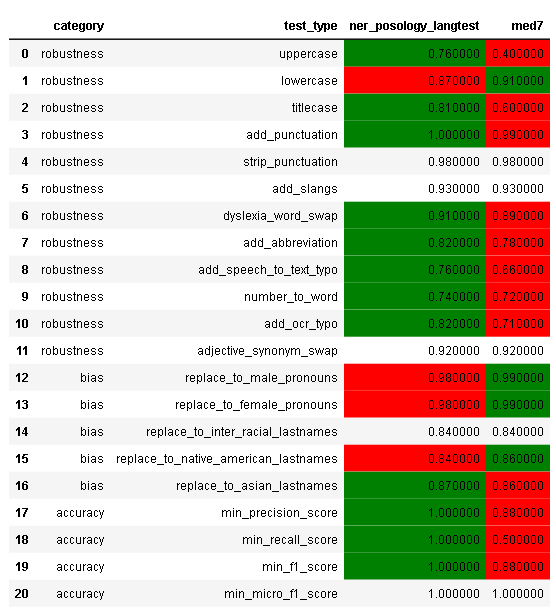

## Conclusion

After evaluating the performance of the `Med7` and `ner_posology_langtest` models in terms of accuracy, robustness, and bias, we can draw the following conclusions:

- **Accuracy:** The "ner_posology_langtest" model demonstrated superior accuracy, achieving a perfect pass rate for all accuracy-related tests. In contrast, the "Med7" model had some failures in precision, recall, and F1 score tests.

- **Robustness:** Both models exhibited robustness in handling various text manipulation tasks. The "ner_posology_langtest" model, in particular, displayed slightly higher pass rates in most tests, indicating its ability to handle a wide range of inputs effectively.

- **Bias:** Both models performed admirably in bias tests, passing all assessments related to gender, and race biases.

Moving forward, it is important to address the identified weaknesses of these models to further enhance their performance. One potential solution is to augment the training set using langtest. By incorporating additional data from langtest. To explore the implementation of langtest for augmentation, you can refer to the [Augmentation Control Notebook](https://github.com/JohnSnowLabs/langtest/blob/main/demo/tutorials/misc/Augmentation_Control_Notebook.ipynb).

Considering these factors, the "ner_posology_langtest" model stands out as the better performer, excelling in accuracy and demonstrating commendable robustness without displaying any biases. However, it's worth noting that further analysis and evaluation may be necessary to obtain a comprehensive understanding of their overall performance.

